# Segmented Model #1: non-capital customers

In [122]:
# Import necessary packages
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.semi_supervised import SelfTrainingClassifier
from sklearn.metrics import roc_auc_score, RocCurveDisplay, classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import RandomOverSampler

In [65]:
import sys
sys.path.append('..')

In [66]:
from src.preprocessing import (
    batch_parse_salary,
    _combine_name_cols,
    combine_time_with_employer,
    import_campaign_table,
    import_mortgage_table
)

In [67]:
campaign_df = import_campaign_table('../data/Campaign.csv')

In [68]:
campaign_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32060 entries, 0 to 32059
Data columns (total 8 columns):
 #   Column                Non-Null Count  Dtype   
---  ------                --------------  -----   
 0   age                   32060 non-null  int64   
 1   marital_status        32060 non-null  category
 2   occupation_level      32060 non-null  int64   
 3   education_num         32060 non-null  int64   
 4   familiarity_FB        32060 non-null  int64   
 5   view_FB               32060 non-null  int64   
 6   interested_insurance  32060 non-null  int64   
 7   created_account       32060 non-null  int64   
dtypes: category(1), int64(7)
memory usage: 1.7 MB


In [69]:
mortgage_df = import_mortgage_table('../data/Mortgage.csv')

Getting exhange rates...


In [70]:
mortgage_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 5 columns):
 #   Column                      Non-Null Count  Dtype   
---  ------                      --------------  -----   
 0   salary_band                 32255 non-null  float64 
 1   hours_per_week              32561 non-null  int64   
 2   workclass                   30725 non-null  category
 3   total_months_with_employer  32561 non-null  int64   
 4   pays_captial_tax            32561 non-null  int64   
dtypes: category(1), float64(1), int64(3)
memory usage: 1.0 MB


In [71]:
# Concat the tables
combined_df = pd.concat([campaign_df, mortgage_df], axis=1)

In [73]:
combined_df.dropna(inplace=True)
combined_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 29959 entries, 0 to 32059
Data columns (total 13 columns):
 #   Column                      Non-Null Count  Dtype   
---  ------                      --------------  -----   
 0   age                         29959 non-null  float64 
 1   marital_status              29959 non-null  category
 2   occupation_level            29959 non-null  float64 
 3   education_num               29959 non-null  float64 
 4   familiarity_FB              29959 non-null  float64 
 5   view_FB                     29959 non-null  float64 
 6   interested_insurance        29959 non-null  float64 
 7   created_account             29959 non-null  float64 
 8   salary_band                 29959 non-null  float64 
 9   hours_per_week              29959 non-null  int64   
 10  workclass                   29959 non-null  category
 11  total_months_with_employer  29959 non-null  int64   
 12  pays_captial_tax            29959 non-null  int64   
dtypes: category(2), 

In [74]:
combined_df.pays_captial_tax.value_counts()

0    26007
1     3952
Name: pays_captial_tax, dtype: int64

In [75]:
non_capital_df = combined_df[combined_df.pays_captial_tax == 0].drop('pays_captial_tax', axis=1)

### Baseline Random Forst Model

In [130]:
# X, y split for labelled data
labelled = non_capital_df[non_capital_df.created_account != -1]
X_lab, y_lab = labelled.drop('created_account', axis=1), labelled['created_account']
X_lab_train, X_lab_test, y_lab_train, y_lab_test = train_test_split(X_lab, y_lab, test_size=0.2, stratify=y_lab)

In [131]:
y_lab_train.value_counts()

0.0    1921
1.0      17
Name: created_account, dtype: int64

So few positive examples. Unlikely that this option is going to work very well at all without some over sampling so will do exactly that. 

In [132]:
y_train.value_counts()

-1.0    23584
 0.0     1201
 1.0       10
Name: created_account, dtype: int64

In [133]:
# random over sampler
ros = RandomOverSampler()

In [134]:
# Baseline Random Forest (use only labelled data)
rdf = RandomForestClassifier()

In [135]:
ct = ColumnTransformer(
    [("one_hot_encode", OneHotEncoder(handle_unknown='ignore'), ["marital_status", "workclass"])],
    remainder='passthrough', verbose_feature_names_out=False
)

In [136]:
pipeline = Pipeline(
    steps=[
        ("over_sampler", ros),
        ("encoder", ct),
        ("random_forest", rdf),
    ]
)

In [137]:
pipeline.fit(X_lab_train, y_lab_train)

Pipeline(steps=[('over_sampler', RandomOverSampler()),
                ('encoder',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('one_hot_encode',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['marital_status',
                                                   'workclass'])],
                                   verbose_feature_names_out=False)),
                ('random_forest', RandomForestClassifier())])

In [138]:
y_proba = pipeline.predict_proba(X_lab_test)[:,1]
y_pred = pipeline.predict(X_lab_test)
y_proba[:10]

array([0.26, 0.  , 0.07, 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ])

Some servere warning signs here already: look how low the probabilities are! There are just too few positive examples and this is probably only being reinforced with the semi-supervised stuff.

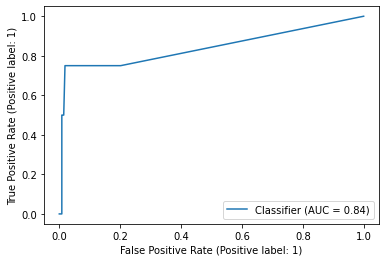

In [139]:
RocCurveDisplay.from_predictions(y_lab_test, y_proba)

In [140]:
classification_report(y_lab_test, y_pred)

/Users/josephiles/Development/cdao_interview/.venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/josephiles/Development/cdao_interview/.venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/josephiles/Development/cdao_interview/.venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  

'              precision    recall  f1-score   support\n\n         0.0       0.99      1.00      1.00       481\n         1.0       0.00      0.00      0.00         4\n\n    accuracy                           0.99       485\n   macro avg       0.50      0.50      0.50       485\nweighted avg       0.98      0.99      0.99       485\n'

We can't even get classification metrics because nothing is being predicted positively. Dropping so many really is a non-starter.

### Ignore the rest from here, larely scrap.

In [76]:
# X, y split for unlabelled training data
unlabelled_train = non_capital_df[non_capital_df.created_account == -1]
X_unlab_train, y_unlab_train = unlabelled_train.drop('created_account', axis=1), unlabelled_train['created_account']

In [103]:
# But training sets back together
X_train = pd.concat((X_unlab_train, X_lab_train))
y_train = pd.concat((y_unlab_train, y_lab_train))

In [114]:
# Train semi-supervised estimator
rfc = RandomForestClassifier()
stc = SelfTrainingClassifier(base_estimator=rfc, verbose=True, threshold=0.9)

In [115]:
stc.fit(X_train, y_train)

ValueError: could not convert string to float: 'Married-civ-spouse'

In [225]:
# Score based on ROC_AUC
y_proba = stc.predict_proba(X_lab_test)[:,1]
roc_auc_score(y_lab_test, y_proba)

0.6149078778233458

We ultimately don't imporove on the score by using the semi-supervised learner - but there are so few labelled examples it's hard to trust the scores.

In [265]:
# Get feature importances
features = dummies_df.drop('created_account', axis=1).columns.to_list()
importances = {}
for ft, imp in zip(features, rdf.feature_importances_):
    importances[ft] = imp

In [266]:
pd.Series(importances).sort_values(ascending=False)

view_FB                                 1.751554e-01
salary_band                             1.444856e-01
hours_per_week                          1.243847e-01
occupation_level                        1.157876e-01
education_num                           9.907655e-02
total_months_with_employer              8.479101e-02
age                                     8.375376e-02
familiarity_FB                          4.192716e-02
workclass_State-gov                     3.872240e-02
workclass_Self-emp-inc                  2.882354e-02
workclass_Private                       1.701060e-02
workclass_Self-emp-not-inc              1.522507e-02
marital_status_Married-civ-spouse       1.235226e-02
interested_insurance                    1.170204e-02
marital_status_Never-married            3.195219e-03
workclass_Local-gov                     2.294433e-03
workclass_Federal-gov                   7.656664e-04
marital_status_Widowed                  4.302227e-04
marital_status_Divorced                 1.1583

## Feature selection

### RFECV

In [119]:
from sklearn.feature_selection import RFECV, RFE
from sklearn.model_selection import StratifiedKFold

In [148]:
cv = StratifiedKFold(n_splits=3)
rfecv = RFECV(estimator=rfc, scoring='roc_auc', cv=cv)

In [154]:
rfecv.fit(X_lab, y_lab)

RFECV(cv=StratifiedKFold(n_splits=3, random_state=None, shuffle=False),
      estimator=RandomForestClassifier(), scoring='roc_auc')

In [155]:
rfecv.n_features_

20

In [156]:
rfecv.cv_results_

{'mean_test_score': array([0.6015633 , 0.66072971, 0.70070793, 0.80124911, 0.84288742,
        0.924722  , 0.92406969, 0.94282552, 0.94633501, 0.95007858,
        0.95171304, 0.92525957, 0.95543197, 0.95058357, 0.94737523,
        0.92549633, 0.95105686, 0.94758293, 0.9294181 , 0.95724478,
        0.94775913, 0.94939068, 0.95400303, 0.94915076, 0.94879786,
        0.92906036]),
 'std_test_score': array([0.06924027, 0.05842937, 0.07272756, 0.03856446, 0.03889707,
        0.04119409, 0.03899897, 0.03365146, 0.03263956, 0.03840799,
        0.04071304, 0.03879528, 0.03716405, 0.03920851, 0.03383404,
        0.07133089, 0.04354161, 0.03440414, 0.07718336, 0.03907929,
        0.03820195, 0.04496877, 0.03989535, 0.04843035, 0.04175423,
        0.07872115]),
 'split0_test_score': array([0.55091849, 0.65828429, 0.63135367, 0.82682361, 0.81514179,
        0.98287854, 0.9792224 , 0.96263599, 0.9698591 , 0.97289103,
        0.97146424, 0.89691457, 0.97806314, 0.97636882, 0.9757446 ,
        0.9813

In [157]:
import matplotlib.pyplot as plt

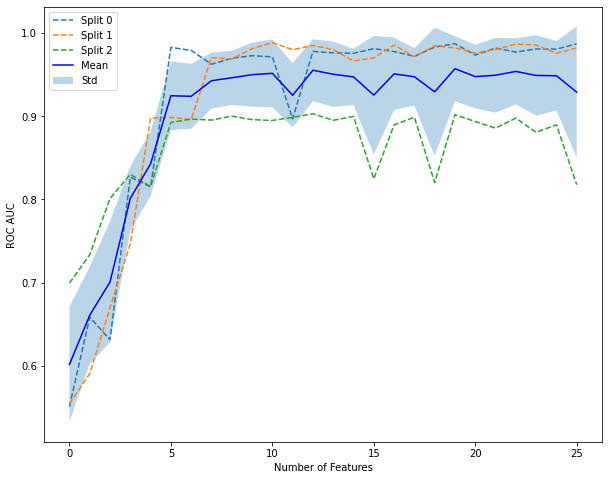

In [168]:
fig, axs = plt.subplots(figsize=(10,8))
cv_results = rfecv.cv_results_

# Plot individual CVs
plt.plot(cv_results['split0_test_score'], '--', label='Split 0')
plt.plot(cv_results['split1_test_score'], '--', label='Split 1')
plt.plot(cv_results['split2_test_score'], '--', label='Split 2')

# Plot mean and std range
plt.plot(cv_results['mean_test_score'], label='Mean', color='blue')
plt.fill_between(
    range(len(cv_results['mean_test_score'])),
    cv_results['mean_test_score'] + cv_results['std_test_score'],
    cv_results['mean_test_score'] - cv_results['std_test_score'],
    linestyle='--',
    alpha=0.3,
    label='Std'
)

plt.legend()
plt.xlabel("Number of Features")
plt.ylabel("ROC AUC")

plt.show()

In [147]:
cv_results['mean_test_score'] + cv_results['std_test_score']

array([0.70753105, 0.68379266, 0.85625871, 0.84554088, 0.93369077,
       0.94515484, 1.02510548, 1.02483102, 0.98392882, 0.99021096,
       0.98898713, 0.9908335 , 0.98630175, 0.98794837, 0.99304794,
       0.98726458, 0.9991369 , 0.98806248, 1.04044582, 0.99169843,
       0.99204976, 0.99300098, 0.99478865, 0.99034668, 0.99450827,
       0.98731277])

In [171]:
rfecv.ranking_

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 4, 1, 7, 1, 3, 1, 2, 1, 1, 1, 5, 1,
       1, 1, 1, 6])

There are so few features here anyway that I'm not sure it's that condusive to bother with removing the features. RFECV recommends 20 features selected out of 26 but that's only six features dropped. Show this in the presentation to show that you've considered it but ultimately I think it's out of scope for this task really.

## Hyperparamter tuning

In [230]:
from sklearn.model_selection import GridSearchCV

parameters = {'n_estimators': (100, 200, 300),
              'max_depth': (None, 5, 10)}

rfc = RandomForestClassifier()

clf = GridSearchCV(rfc, parameters, verbose=True)

clf.fit(X_lab, y_lab)

Fitting 5 folds for each of 9 candidates, totalling 45 fits


GridSearchCV(estimator=RandomForestClassifier(),
             param_grid={'max_depth': (None, 5, 10),
                         'n_estimators': (100, 200, 300)},
             verbose=True)

In [235]:
best_rdf = clf.best_estimator_
cross_val_score(best_rdf, X_lab, y_lab, scoring='roc_auc')

array([0.99142412, 0.98050936, 0.99      , 0.97604167, 0.8375    ])

In [245]:
from sklearn.metrics import RocCurveDisplay
RocCurveDisplay.from_predictions(y_lab_test, y_lab_pred)

NameError: name 'y_lab_pred' is not defined